# Ford GoBike Data Exploration
## by Jumba Mark


## Investigation Overview

* In this investigation, I wanted to focus on the following questions:
    1. when are most trips taken in terms of time of day and day of week
    2. How long does the average trip take?
    3. Does the above depend on if a user is a subscriber or customer?


## Dataset Overview

This data includes information about 183412 individual rides made in a bike-sharing system covering the greater San Francisco Bay area in the month of February. The attributes included duration, user type, start/end time, as well as additional information such as bike id, rental access method, start/end station, etc. The dataset was cleaned by removing outliers in the Exploration step while erroneous data types were corrected in the wrangling step. The following columns that were not related to the research questions were removed; `start_station_id`, `start_station_name`,`end_station_id`, `end_station_name`, and `bike_id`

In [56]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import calendar

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [57]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

# clean the dataset
df_clean = df.copy()

# remove the null values
df_clean = df.dropna()

# Use pd.to_datetime to convert datatype to datetime
df_clean.start_time = pd.to_datetime(df_clean.start_time)
df_clean.end_time = pd.to_datetime(df_clean.end_time)

# Use astype(str) to convert datatype to str
df_clean.start_station_id = df_clean.bike_id.astype(str)
df_clean.end_station_id = df_clean.bike_id.astype(str)
df_clean.bike_id = df_clean.bike_id.astype(str)

# Use astype('category') to set user type, bike_share_for_all_trip, rental_access_method to category
df_clean.user_type = df_clean.user_type.astype('category')
df_clean.member_gender = df_clean.member_gender.astype('category')

# change the type of 'member_birth_year'
df_clean.member_birth_year = df_clean.member_birth_year.astype(int)

# changing datatype to boolean
df_clean.bike_share_for_all_trip = (df_clean.bike_share_for_all_trip == 'Yes')

# remove the columns that are unrelated to the research question
df_clean.drop(columns=['start_station_id', 'start_station_name','end_station_id', 'end_station_name', 'bike_id'], inplace=True)


## Distribution of Bikes Ride Duration
Bike ride duration in the dataset take on a very large range of values, from `61` at the lowest to `84548` at the highest. By removing outliers and plotting on a logarithmic scale, the distribution of bike ride duration look more like normal distribution with peak at little less than 500 seconds. Most bike rides are short trips.

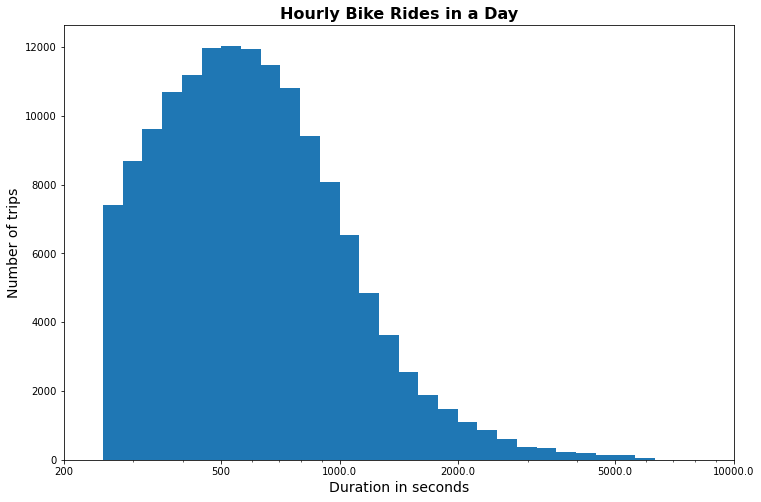

In [58]:
duration_filter = df_clean.query('duration_sec < 6000')
log_binsize = 0.05
bins = 10 ** np.arange(2.4, np.log10(duration_filter['duration_sec'].max())+log_binsize, log_binsize)

plt.figure(figsize=[12, 8])
plt.hist(data=duration_filter, x='duration_sec', bins=bins)
plt.xscale('log')
# Set ticks in cycles of 1-3-10 or 1-2-5-10 are very useful for base-10 log transforms.
tick_locs = [200, 500, 1e3, 2e3, 5e3, 1e4]
plt.xticks(tick_locs, tick_locs)
plt.xlabel('Duration in seconds', fontsize=14)
plt.ylabel('Number of trips', fontsize=14)
plt.title('Hourly Bike Rides in a Day', fontsize=16, fontweight='bold')
plt.show()


## Ford GoBike User Types
Majority of the bike users are subscribers(90.5%). Customers take up 9.5%

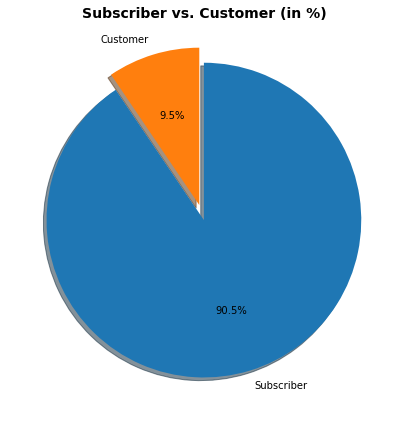

In [59]:
plt.figure(figsize=[12, 6], facecolor='w')
explode = (0, 0.1)
sorted_counts = df_clean['user_type'].value_counts()
plt.pie(sorted_counts, explode=explode, labels=sorted_counts.index, autopct='%1.1f%%', shadow=True, startangle=90, counterclock=False)
plt.title('Subscriber vs. Customer (in %)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Average Ride Duration: Subscribers vs. Customers
Although subscribers make a lot more trips than customers, customers generally take longer bike trip than subscribers.

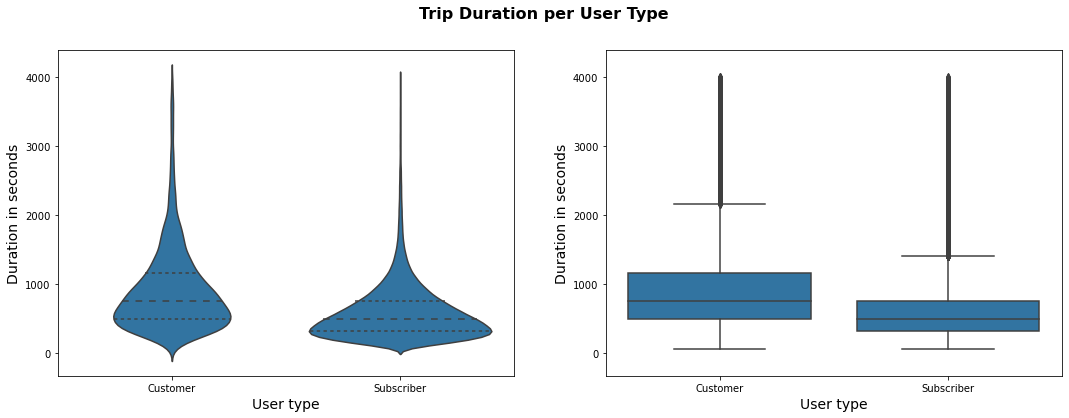

In [60]:
# Set an upper limit of 4000 to remove outliers for the graphs
fig = plt.figure(figsize=[18, 6])
base_color = sb.color_palette()[0]
filter_data = df_clean.query('duration_sec < 4000')

# left plot: violin plot
plt.subplot(1, 2, 1)
ax1 = sb.violinplot(data=filter_data, x='user_type',y='duration_sec', color=base_color, inner='quartile')
plt.xlabel('User type', fontsize=14)
plt.ylabel('Duration in seconds', fontsize=14)

# right plot: box plot
plt.subplot(1, 2, 2)
sb.boxplot(data=filter_data, x='user_type', y='duration_sec', color=base_color)
plt.xlabel('User type' , fontsize=14)
plt.ylabel('Duration in seconds', fontsize=14)
plt.ylim(ax1.get_ylim())  # set y-axis limits to be same as left plot
fig.suptitle('Trip Duration per User Type', fontsize=16, fontweight='bold')
plt.show()


## Bike Usage in Hour and Day: Subscribers vs. Customers

- Different user types does show different usage(in number of rides) patterns.
    * Subscribers take most of their trips around 7-9am(peak at 8am) and 4-6pm(peak at 5pm), typical commute hours. They are probably commuters to work/school.  Subscribers took more trips during the weekdays and less on weekend.
    * The usage trend for customers is relatively constant during the week but with higher usage on Thursday and Friday. Customers show similar pattern with subscribers on a daily basis except that customers take less morning trips.

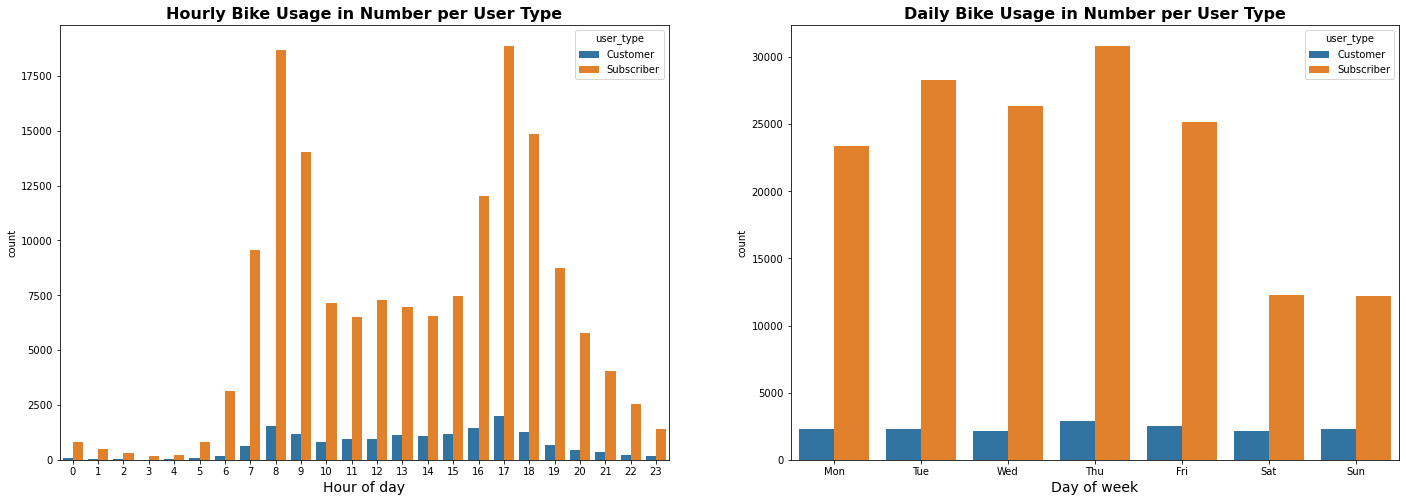

In [61]:
# Create month, dayofweek, hour columns for start date
df_clean['start_month'] = pd.DatetimeIndex(df_clean['start_time']).month
df_clean['start_weekday'] = df_clean.start_time.dt.weekday
df_clean['start_hour'] = df_clean.start_time.dt.hour

# Transform month number to abbrieviated month name, dayofweek number to day name
df_clean['start_month'] = df_clean['start_month'].apply(lambda x: calendar.month_abbr[x])
df_clean['start_weekday'] = df_clean['start_weekday'].apply(lambda x: calendar.day_abbr[x])

# Number of bike rides per hour per user type
fig = plt.figure(figsize=[24, 8])
plt.subplot(1, 2, 1)
sb.countplot(data=df_clean, x='start_hour', hue='user_type')
plt.xlabel('Hour of day', fontsize=14)
plt.title('Hourly Bike Usage in Number per User Type', fontsize=16, fontweight='bold')


# Number of bike rides per day per user type
plt.subplot(1, 2, 2)
order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sb.countplot(data=df_clean, x='start_weekday', hue='user_type', order=order)
plt.xlabel('Day of week', fontsize=14)
plt.title('Daily Bike Usage in Number per User Type', fontsize=16, fontweight='bold')
plt.show()


## Average Bike Trip Duration in Hour and Day: Subscribers vs. Customers

* Average ride duration in hour and weeday confirms that customers generally take longer trips than subscribers.
* Both subscribers and customers take longer trips during weekend than weekdays.
* Houly average duration for customers are higher between 10am-5pm reaching its peak at 2pm.

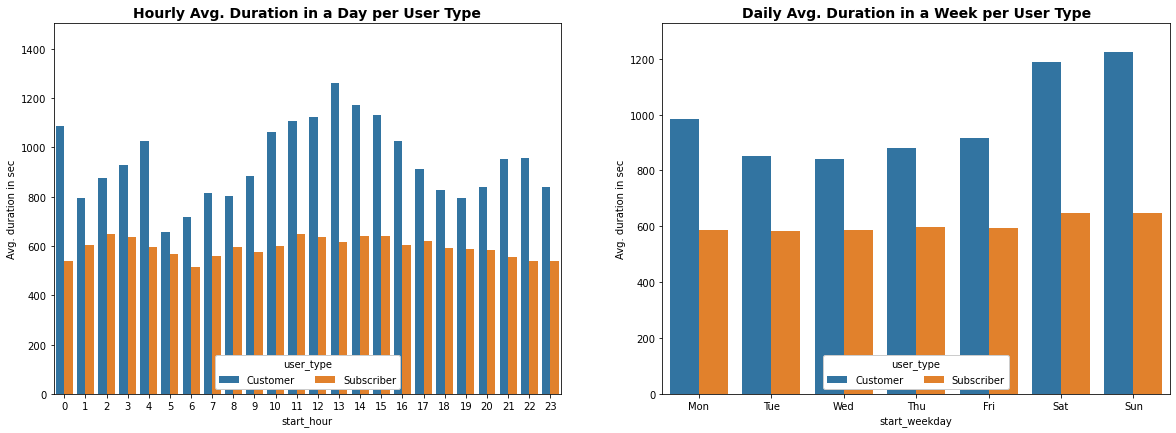

In [62]:

plt.figure(figsize=(20, 15))
base_color = sb.color_palette()[0]

# Hourly Avg. Duration in a Day per User Type
plt.subplot(221)
ax = sb.barplot(data=df_clean.query('duration_sec < 6000'),x='start_hour', y='duration_sec', hue='user_type', errwidth=0)
ax.legend(loc=8, ncol=3, framealpha=1, title='user_type')
plt.ylabel('Avg. duration in sec')
plt.title('Hourly Avg. Duration in a Day per User Type',fontsize=14, fontweight='bold')

# Daily Avg. Duration in a Week per User Type
plt.subplot(222)
order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sb.barplot(data=df_clean.query('duration_sec < 6000'), x='start_weekday', y='duration_sec', hue='user_type',errwidth=0, order=order)
ax.legend(loc=8, ncol=3, framealpha=1, title='user_type')
plt.ylabel('Avg. duration in sec')
plt.title('Daily Avg. Duration in a Week per User Type',fontsize=14, fontweight='bold');

## Bike Rides 24x7: Subscribers vs. Customers
The heatmap for different user types strengthened the results we've discussed eariler in the bivariate exploration section. Different user types show different usage(in number of rides) patterns. Subscribers take most of their trips during weekdays around 7-9am(peak at 8am) and 4-6pm(peak at 5pm). For customers, 8am-6pm is the popular time period to rent the bike. Bike usage for customers has one peak at 5pm and another peak at 8am, which is much less than the peak at 5pm. The usage trend for customers is relatively constant during the week but with higher usage on the weekend.

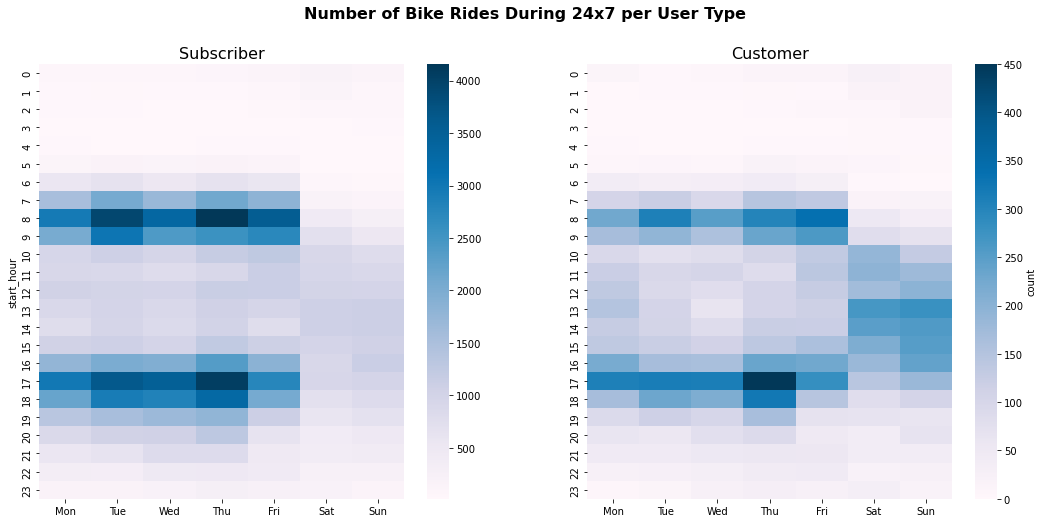

In [63]:
# Number of bike rides taken place during 24x7
plt.figure(figsize=(18, 8))
df_clean['start_weekday'] = pd.Categorical(df_clean['start_weekday'], categories=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)
filter_data = df_clean.query('duration_sec < 6000')

# left plot: subscriber
plt.subplot(1, 2, 1)
rides_count_s = filter_data.query('user_type == "Subscriber"').groupby(['start_weekday', 'start_hour']).size().astype(int)
rides_count_s = rides_count_s.reset_index(name='count')
rides_count_s = rides_count_s.pivot(
    index='start_hour', columns='start_weekday', values='count')
ax1 = sb.heatmap(rides_count_s, cmap='PuBu')
plt.xlabel('')
plt.title('Subscriber', fontsize=16)
ax1.set_ylim(23.5 + 0.5, 0.5 - 0.5)  # ax1.get_ylim() -- (23.5, 0.5)

# right plot: customer
plt.subplot(1, 2, 2)
rides_count_c = filter_data.query('user_type == "Customer"').groupby(['start_weekday', 'start_hour']).size().astype(int)
rides_count_c = rides_count_c.reset_index(name='count')
rides_count_c = rides_count_c.pivot(index='start_hour', columns='start_weekday', values='count')
ax2 = sb.heatmap(rides_count_c, cmap='PuBu', cbar_kws={'label': 'count'})
plt.xlabel('')
plt.ylabel('')
plt.title('Customer', fontsize=16)
plt.suptitle('Number of Bike Rides During 24x7 per User Type', fontsize=16, fontweight='bold')
plt.ylim(ax1.get_ylim());   # set y-axis limits to be same as left plot